In [ ]:
# This is the model in which we write the algorthim to decide how to allocate portfolio weights 
# This will ultimately output a dataset which all the user needs to do is just use the backtesting functionality
# that we end up writing out in a python notebook to get the plots that we need to analyze what we are working on
# class PortfolioModel:
#     def __init__(self, symbols: dict=Basket().get_portfolio()):
#         self.symbols = symbols
#         self.add = Ticker().recommend_tickers()
    
#     def add_tickers(self, tickers: list):
#         if tickers == self.add:

    
#     def get_tickers(self):
#         pass

In [139]:
import retrieve_tickers as rt
import bt

tickers = list(rt.Basket().get_portfolio().keys())

tickers.extend(["YMM", "CORT", "DLO"])

df = bt.get(tickers,start="2020-01-01")


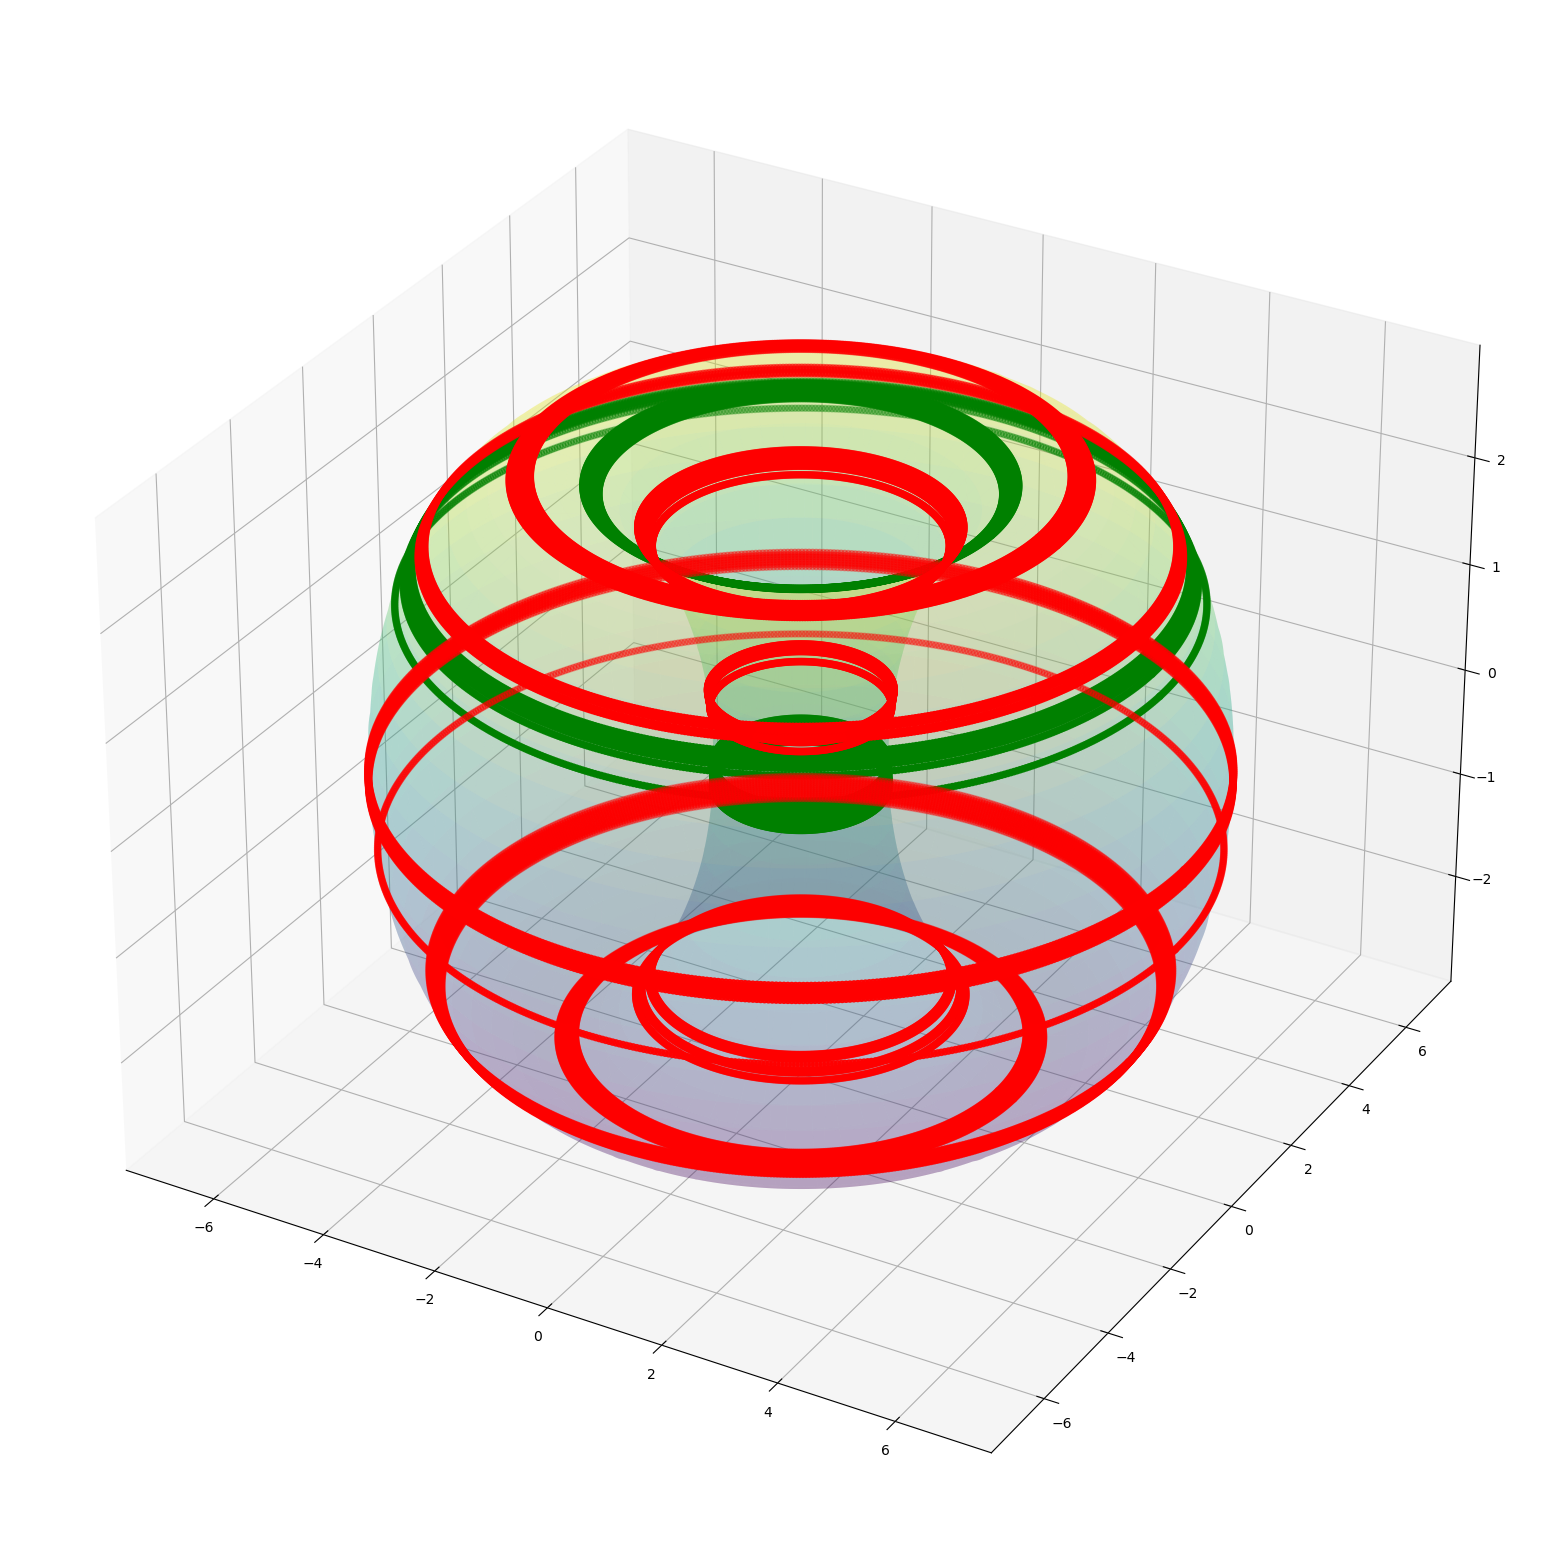

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_torus(ticker,big,rolling_mean,rolling_std,buy_signal,sell_signal,size):
    # Define parametric equations for a torus
    def torus_parametric(u, v, R, r):
        x = (R + r * np.cos(v)) * np.cos(u)
        y = (R + r * np.cos(v)) * np.sin(u)
        z = r * np.sin(v)
        return x, y, z

    # Parameters for the torus
    R = (rolling_mean[ticker] + (2 * rolling_std[ticker])).mean()  # Major radius
    r = rolling_mean[ticker].mean()  # Minor radius

    # Generate torus coordinates
    u = np.linspace(0,big,size)
    v = np.linspace(0,big,size)
    U, V = np.meshgrid(u, v)
    X, Y, Z = torus_parametric(U, V, R, r)

    # Plot the torus
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, alpha=0.2, cmap='viridis')

    # Plot the price data
    ax.scatter(X[buy_signal[ticker]], Y[buy_signal[ticker]], Z[buy_signal[ticker]], color='g', label='Buy Signal')
    ax.scatter(X[sell_signal[ticker]], Y[sell_signal[ticker]], Z[sell_signal[ticker]], color='r', label='Sell Signal')
    ax.tick_params(labelsize=10)
    
    plt.show()

big = 2*np.pi

df_filter = df - df.iloc[0]

norm_price = (df_filter - df_filter.min()) / (df_filter.max() - df_filter.min()) * big

rolling_mean = norm_price.rolling(window=50).mean()
rolling_std = norm_price.rolling(window=50).std()

buy_signal = norm_price < rolling_mean - (2 * rolling_std)
sell_signal = norm_price > rolling_mean + (2 * rolling_std)

plot_torus("cort",big,rolling_mean,rolling_std,buy_signal,sell_signal,len(df))

In [144]:
def action_tickers(ticker,buy_indicator,sell_indicator):
    tick_buy = pd.DataFrame(buy_indicator[ticker])
    tick_buy["BuySignal"] = "Buy"
    tick_buy = tick_buy.rename(columns={ticker:"BuyAction"})

    tick_sell = pd.DataFrame(sell_indicator[ticker])
    tick_sell["SellSignal"] = "Sell"
    tick_sell = tick_sell.rename(columns={ticker:"SellAction"})

    actions = pd.concat([tick_buy,tick_sell],axis=1)
                     
    actions.loc[(actions["BuyAction"] == False) & (actions["SellAction"] == False), ["BuySignal","SellSignal"]] = "Hold"

    buy = actions.loc[(actions["BuySignal"] == "Buy") & (actions["BuyAction"] == True), "BuySignal"]
    sell = actions.loc[(actions["SellSignal"] == "Sell") & (actions["SellAction"] == True), "SellSignal"]
    hold = actions.loc[(actions["BuySignal"] == "Hold") & (actions["SellSignal"] == "Hold"), "BuySignal"]

    actions = pd.concat([buy,sell,hold],axis=0).reset_index()

    actions.columns = ["Date", ticker + "Signal"]

    actions = actions.sort_values(by="Date",ascending=True).reset_index(drop=True)

    actions = actions.drop(["Date"],axis=1)

    return actions

ticker_action = pd.DataFrame(buy_signal.index)

for tick in tickers:
    ticker_action[tick.lower() + "Signal"] = action_tickers(tick.lower(),buy_signal,sell_signal)

date = ticker_action.pop("Date")
ticker_action = ticker_action.set_index(date)

ticker_action.iloc[51:]

,cdlxSignal,cvxSignal,pyplSignal,modSignal,calmSignal,indaSignal,anfSignal,ymmSignal,cortSignal,dloSignal
Date,,,,,,,,,,
2021-09-03,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Hold,Hold,Hold
2021-09-07,Hold,Hold,Hold,Hold,Sell,Sell,Hold,Hold,Hold,Hold
2021-09-08,Hold,Hold,Hold,Hold,Sell,Sell,Hold,Hold,Hold,Hold
2021-09-09,Hold,Hold,Hold,Hold,Hold,Sell,Hold,Hold,Hold,Hold
2021-09-10,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold
...,...,...,...,...,...,...,...,...,...,...
2024-05-13,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Sell,Hold
2024-05-14,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Hold,Sell,Hold
2024-05-15,Hold,Hold,Hold,Sell,Hold,Hold,Hold,Hold,Sell,Buy


tailAction
0% [############################# ] 100% | ETA: 00:00:00

<Axes: title={'center': 'Equity Progression'}>

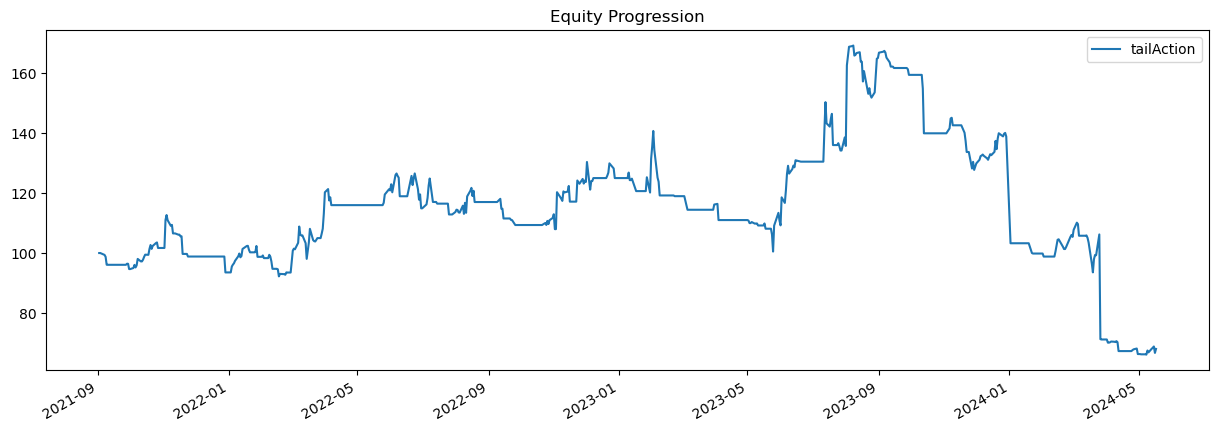

In [145]:
strat = bt.Strategy('tailAction', [bt.algos.SelectWhere(sell_signal),
                                   bt.algos.WeighEqually(),
                                   bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(strat, df.iloc[51:,:],integer_positions=False, progress_bar=True)

# and let's run it!
res = bt.run(t)

res.plot()

tailAction
0% [############################# ] 100% | ETA: 00:00:00

<Axes: title={'center': 'Equity Progression'}>

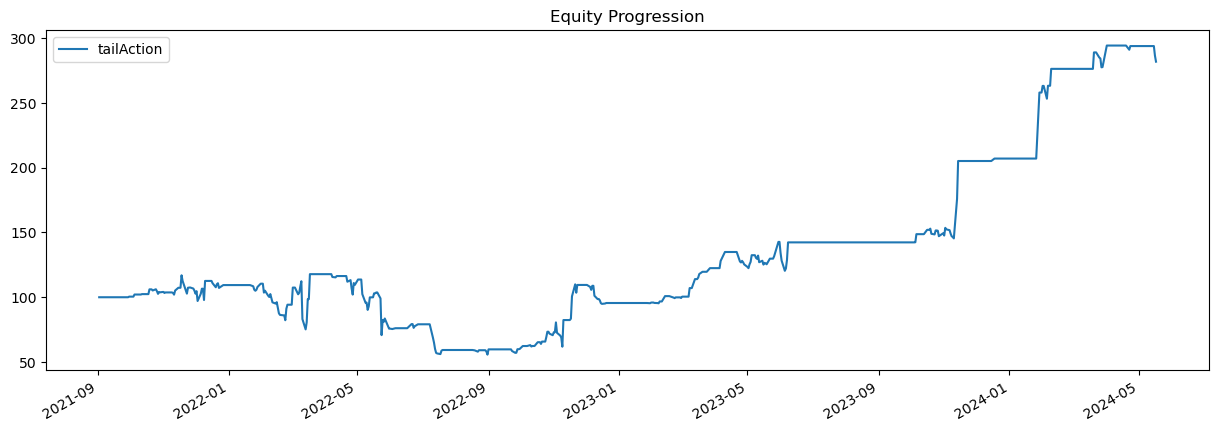

In [146]:
strat = bt.Strategy('tailAction', [bt.algos.SelectWhere(buy_signal),
                                   bt.algos.WeighEqually(),
                                   bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(strat, df.iloc[51:,:],integer_positions=False, progress_bar=True)

# and let's run it!
res = bt.run(t)

res.plot()